In [3]:
import os
import glob
import numpy as np
import pandas as pd

import obspy
from obspy import Stream, read, read_inventory, Inventory

ncedc_pick_dir = '../data/NCEDC_picks'

file_list = [f'{year}.txt' for year in range(2008, 2024)]
print(file_list)

['2008.txt', '2009.txt', '2010.txt', '2011.txt', '2012.txt', '2013.txt', '2014.txt', '2015.txt', '2016.txt', '2017.txt', '2018.txt', '2019.txt', '2020.txt', '2021.txt', '2022.txt', '2023.txt']


# NCEDC picks to a Dictionary

In [2]:
from classes_functions.NCEDC_picks_converter import NCEDC_picks_2_dict

my_dict = {}
for file in file_list[:]:
  dict = NCEDC_picks_2_dict(ncedc_pick_dir, file)
  my_dict.update(dict)

print(len(list(my_dict.keys())))
print(list(my_dict.keys())[-10:])

for line in my_dict[list(my_dict.keys())[-1]]:
  print(line)
  break


7312
['nc73979931', 'nc73980066', 'nc73980546', 'nc73980711', 'nc73981126', 'nc73981181', 'nc73981716', 'nc73981981', 'nc73982056', 'nc73982061']
['nc73982061', '2023-12-28T12:03:26.22', 40.4025, 125.10833333333333, 10.0, 3.5, 'BG.AL1..DPZ', 'P', '', '2023-12-28T12:04:2.73']


# Convert into a Dataframe 

In [3]:
df_list = []
# put the dict into a dataframe
for k, v in my_dict.items():
    temp_df = pd.DataFrame(
        v, 
        columns=['event_id', 'etime', 'elat', 'elon', 'edep', 'emag', 'station_id', 'phase_type', 'phase_polarity', 'phase_time'])
    df_list.append(temp_df)

# combine the dataframes into one
master_df = pd.concat(df_list)

# convert lat and lon to float and round to 7 decimal places and times to datetime
master_df['elat'] = master_df['elat'].astype(float)
master_df['elon'] = master_df['elon'].astype(float) * -1
master_df['etime'] = pd.to_datetime(master_df['etime'])
master_df['phase_time'] = pd.to_datetime(master_df['phase_time'])

# filter out events outside of the region of interest
master_df = master_df[
    (master_df['elat'] >= 39.75) & (master_df['elat'] <= 41.5) 
    & (master_df['elon'] >= -125.5) & (master_df['elon'] <= -123)]

# keep only picks ending with 'Z' or '3'
master_df = master_df[master_df['station_id'].str.endswith(('Z', '3'))]

# write to csv
master_df.to_csv(f'{ncedc_pick_dir}/NCEDC_picks_50km.csv', index=False)

print(master_df.shape)
master_df.head()

(253161, 10)


,event_id,etime,elat,elon,edep,emag,station_id,phase_type,phase_polarity,phase_time
0,nc51193680,2008-01-01 05:58:18.290,40.7805,-123.561333,20.32,2.04,BK.JCC..HHZ,P,U,2008-01-01 05:58:26.220
1,nc51193680,2008-01-01 05:58:18.290,40.7805,-123.561333,20.32,2.04,BK.WDC..HHZ,P,U,2008-01-01 05:58:33.060
2,nc51193680,2008-01-01 05:58:18.290,40.7805,-123.561333,20.32,2.04,NC.KBS..SHZ,P,D,2008-01-01 05:58:34.270
3,nc51193680,2008-01-01 05:58:18.290,40.7805,-123.561333,20.32,2.04,NC.KCR..SHZ,P,U,2008-01-01 05:58:27.140
4,nc51193680,2008-01-01 05:58:18.290,40.7805,-123.561333,20.32,2.04,NC.KCS..SHZ,P,U,2008-01-01 05:58:24.930


# Make a Catalog

In [5]:
#extract events catalog from picks df
eq_df = master_df[
    'event_id', 'etime', 'elat', 'elon', 'edep', 'emag'
    ].drop_duplicates(subset='event_id').reset_index(drop=True)

# write in USGS format
eq_df.to_csv(
    f'{ncedc_pick_dir}/NCEDC_eq_cat_50km.csv', 
    index=False, header=False,
    columns=['id', 'time', 'latitude', 'longitude', 'depth', 'magnitude'])

print(eq_df.shape)
eq_df.head()

(7312, 6)


,event_id,etime,elat,elon,edep,emag
0,nc51193680,2008-01-01 05:58:18.290,40.780500,-123.561333,20.32,2.04
1,nc71092841,2008-01-06 05:52:36.260,40.481667,-124.594000,20.24,2.44
2,nc71093761,2008-01-13 02:34:14.790,40.882667,-123.681667,11.23,2.23
3,nc71093956,2008-01-14 09:30:08.410,40.627333,-124.247333,13.45,1.81
4,nc51194589,2008-01-14 19:11:31.050,40.779833,-123.564000,22.51,2.50


# Above slab2 interface events

In [6]:
from scipy.interpolate import griddata

cat_folder = f"../data/eq_data/1_eq_catalogs"
# slab2_file = f"{cat_folder}/slab2_subset.csv"
slab2_nonan_file = f"{cat_folder}/slab2_subset_no_nan.csv"

# Load data
slab2_no_nan = pd.read_csv(slab2_nonan_file)

# intepolate slab depth to the earthquake locations
# and add the slab depth to the eq_df as a new column
eq_df['slab_depth'] = griddata(
    (slab2_no_nan['lon'], slab2_no_nan['lat']), 
    slab2_no_nan['depth'], 
    (eq_df['elon'], eq_df['elat']), method='linear'
    )

# select earthquakes with slab_depth column is not NaN
eq_in_slab2_area_df = eq_df[~np.isnan(eq_df['slab_depth'])] # ~ means not

# make slab_depth column positive because earthquake depth are also positive
eq_in_slab2_area_df.loc[:, 'slab_depth'] = -eq_in_slab2_area_df.slab_depth

# get above slab earthquakes i.e. eq depth < slab depth
above_slab_eq_df = eq_in_slab2_area_df[
    eq_in_slab2_area_df['edep'] < eq_in_slab2_area_df['slab_depth']
    ]

above_slab_eq_df.to_csv(f'{ncedc_pick_dir}/NCEDC_eq_cat_above_slab.csv', index=False)

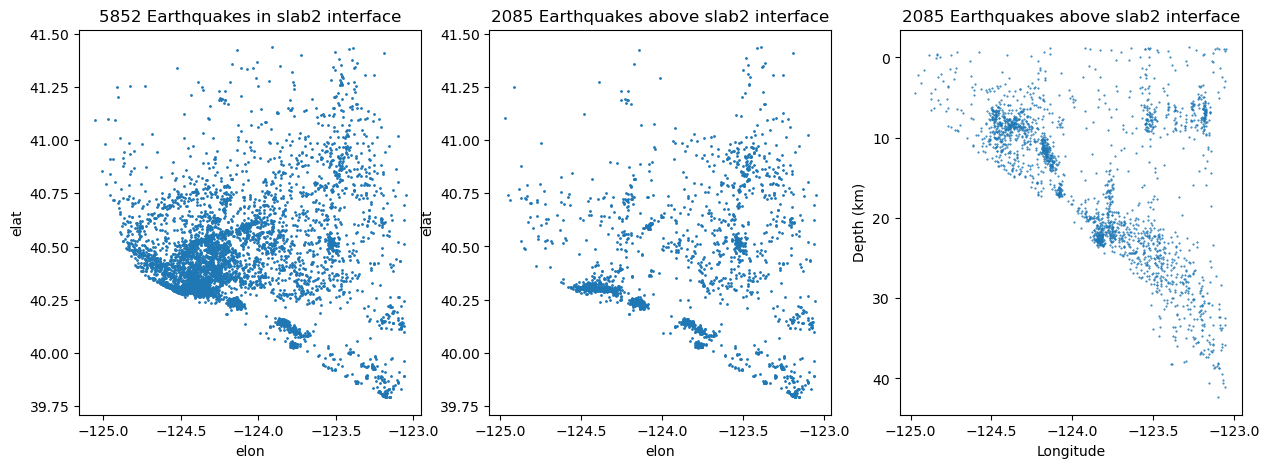

In [10]:
# plot
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
ax1, ax2, ax3 = axs

eq_in_slab2_area_df.plot.scatter(x='elon', y='elat', s=1, ax=ax1)
ax1.set_title(f'{eq_in_slab2_area_df.shape[0]} Earthquakes in slab2 interface')

above_slab_eq_df.plot.scatter(x='elon', y='elat', s=1, ax=ax2)
ax2.set_title(f'{above_slab_eq_df.shape[0]} Earthquakes above slab2 interface')

# cross section
ax3.plot(above_slab_eq_df.elon, above_slab_eq_df.edep, '.', markersize=1)
ax3.invert_yaxis()
ax3.set_xlabel('Longitude'), ax3.set_ylabel('Depth (km)')
ax3.set_title(f'{above_slab_eq_df.shape[0]} Earthquakes above slab2 interface')

plt.show()

# Finally, convert into PyRocko format phase picks file
### Change command to create for entire data or year by year.

In [11]:
# select picks for above slab earthquakes
above_slab_picks_df = master_df[master_df['event_id'].isin(above_slab_eq_df['event_id'])]
above_slab_picks_df = above_slab_picks_df.sort_values(['etime', 'event_id']).reset_index(drop=True)
above_slab_picks_df.to_csv(f'{ncedc_pick_dir}/NCEDC_picks_above_slab.csv', index=False)

# group by year of the event
above_slab_picks_df['year'] = above_slab_picks_df['etime'].dt.year

for iyear, year_df in above_slab_picks_df.groupby('year'):
    
    year_df = year_df.drop(columns='year')
    year_df.to_csv(f'{ncedc_pick_dir}/{iyear}_NCEDC_picks_above_slab.csv', index=False)

    from classes_functions.NCEDC_files_converter import NCEDC_HypoInverse_reader
    nchypoinv = NCEDC_HypoInverse_reader()

    nchypoinv.df_to_pyrocko_marker(
        picks_df=year_df, 
        output_dir=ncedc_pick_dir, 
        file_name=f'{iyear}_NCEDC_picks_above_slab_pyrocko.txt'
    )
    
    # pyrocko_fmt = []
    # # convert the dataframe to PyRocko format text file
    # for ig, groupdf in year_df.groupby('event_id'):

    #     # generate 27 char random string
    #     random_string = ''.join(random.choices(string.ascii_letters + string.digits, k=27)) + '='
        
    #     # event line
    #     etime_formatted = pd.to_datetime(groupdf.iloc[0]['etime']).strftime('%Y-%m-%d %H:%M:%S.%f')[:-2]
    #     event_line = f"event: {etime_formatted}  0 {random_string}   "
    #     event_line += f"{groupdf.iloc[0]['elat']:.7f} {groupdf.iloc[0]['elon']:.7f}         "
    #     event_line += f"{groupdf.iloc[0]['edep']:.2f} {groupdf.iloc[0]['emag']:.2f} None  {groupdf.iloc[0]['event_id']} None\n" # dep, mag, ???, event_id, ???
        
    #     pyrocko_fmt.append(event_line)
    #     # print((event_line))

    #     for i, row in groupdf.iterrows(): 
    #         phase_time_obj = pd.to_datetime(row['phase_time'])
    #         part1 = f"phase: {phase_time_obj.strftime('%Y-%m-%d %H:%M:%S.%f')[:-2]}  0 "
    #         part2 = f"{row.station_id.ljust(15)}  {random_string} {etime_formatted} "
    #         if row.phase_polarity == 'U':
    #             polarity = 1
    #         elif row.phase_polarity == 'D':
    #             polarity = -1
    #         else:
    #             polarity = 'None'
    #         part3 = f"{row.phase_type}          {str(polarity).rjust(4)} False\n"

    #         phase_line = part1 + part2 + part3
            
    #         pyrocko_fmt.append(phase_line)

    # with open(f'{ncedc_pick_dir}/{iyear}_NCEDC_picks_above_slab_pyrocko.txt', 'w') as f:
    #     f.write('# Snuffler Markers File Version 0.2\n')
    #     f.writelines(pyrocko_fmt)

# Download data
# Obspy.MassDownloader is much better
['HHZ', 'BHZ', 'HNZ', 'EHZ', 'SHZ', 'DPZ', 'SLZ', 'CNZ', 'HN3', 'HH3', 'ENZ']
these are the channels for which ncedc have picks. So we use these channels and the 1st four 
broadband channels from our previous priority channels.

In [70]:
# from classes_functions.get_WF_parallel_class import GetWF_Circular
# %reload_ext autoreload
# %autoreload 2

# ncedc_eqcat_df = pd.read_csv(f'../data/NCEDC_picks/NCEDC_eq_cat_above_slab.csv')#.groupby('event_id')

# preffered_channels = ['HHZ', 'BHZ', 'HNZ', 'EHZ', 'SHZ', 'DPZ', 'SLZ', 'CNZ', 'HN3', 'HH3', 'ENZ']
# channels_string = ",".join(preffered_channels)

# gwfc = GetWF_Circular(client_list = ["NCEDC", "IRIS"])

# for i, row in ncedc_eqcat_df[:1].iterrows():
#     st, inv = gwfc.GetWF_1event(
#         row,
#         channels_string,
#     )
    
#     # write to file
#     down_dir = '../data/eq_data/2_waveforms/test'
#     os.makedirs(f'{down_dir}/mseed', exist_ok=True)
#     os.makedirs(f'{down_dir}/stationxml', exist_ok=True)
#     st.write(f'{down_dir}/mseed/{row.event_id}.mseed', format='MSEED')
    # inv.write(f'{down_dir}/stationxml/{row.event_id}.xml', 'STATIONXML')